In [1]:
# Add gradient clipping
# Add strange noise
# reduced the learning rates

In [2]:
from unityagents import UnityEnvironment

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections.abc import Iterable
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import copy
ewma = lambda x: pd.Series(x).ewm(span=1000).mean()

In [4]:
env_path = "../envs/Reacher_Windows_x86_64/Reacher.exe"

In [5]:
env = UnityEnvironment(env_path)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
env_info = env.reset(train_mode=True)[brain_name]

In [8]:
num_agents = len(env_info.agents)

In [9]:
action_size = brain.vector_action_space_size

In [10]:
state = env_info.vector_observations
state_size = state.shape[1]

In [11]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
score = 0
done = False
c = 0
while not done:
    # take random action
    action = np.random.randn(num_agents, action_size)
    env_info = env.step(action)[brain_name]
    state = env_info.vector_observations
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    c += 1
    if c%100:
        break

In [12]:
# DDPG Agent

class DDPGAgent():
    def __init__(self, critic_arch, actor_arch, state_size, action_size, tau, epsilon, gamma):
        self.critic_local = critic_arch(state_size, action_size)
        self.critic_target = critic_arch(state_size, action_size)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=1e-4)
        
        self.actor_local = actor_arch(state_size, action_size)
        self.actor_target = actor_arch(state_size, action_size)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=1e-5)

        # Equalize target and local networks
        self._soft_target_update(tau = 1) 

        # Noise
        self.noise = OUNoise(action_size, np.random.rand())
        
        self.tau = tau
        self.epsilon = epsilon
        self.gamma = gamma
    
    def update(self, states, actions, rewards, next_states, dones):
        self._update_critic(states, actions, rewards, next_states, dones)
        self._update_actor(states)
        self._soft_target_update()
        
    def reset(self):
        self.noise.reset()
    
    def get_greedy_actions(self, states, evaluation=False):
        if evaluation:
            self.actor_local.eval()
        actions = self.actor_local.predict(states)
        if evaluation:
            self.actor_local.train()
        return actions
    
    def get_actions(self, states, epsilon=None, evaluation=False):
        if epsilon is None:
            epsilon = self.epsilon

        actions = self.get_greedy_actions(states, evaluation)
        actions +=  self.noise.sample() #epsilon*np.random.randn(*actions.shape)
        actions = np.clip(actions, -1, 1)
        return actions
    
    def _soft_target_update(self, tau=None):
        if tau is None:
            tau = self.tau
        self.critic_target.copy_weights_from(self.critic_local, tau)
        self.actor_target.copy_weights_from(self.actor_local, tau)
    
    def _update_critic(self, states, actions, rewards, next_states, dones):
        # Calculate td target
        rewards =  torch.from_numpy(rewards).float()
        dones = torch.from_numpy(dones+0).float()
        
        next_actions = self.actor_target.predict(next_states, tensor=True)
        q_value_next_max = self.critic_target.predict(next_states, next_actions, tensor=True)
        q_value_target = rewards + self.gamma * q_value_next_max * (1-dones)
        #q_value_target = torch.from_numpy(q_value_target).float()
        # Calculate the loss
        q_value_current = self.critic_local.predict(states, actions, tensor=True)
        
        loss = F.mse_loss(q_value_current, q_value_target)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
    
    def _update_actor(self, states):
        actions_predicted = self.actor_local.predict(states, tensor=True)
        critic_action_values = self.critic_local.predict(states, actions_predicted, tensor=True)
        # Calculate the loss
        loss = -critic_action_values.mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()
        

        
    
# Model critic
class CriticArchitecture(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticArchitecture, self).__init__()
        if isinstance(state_size, Iterable):
            assert len(state_size)==1
            state_size = state_size[0]
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(state_size, 256) 
        self.bn1 = nn.BatchNorm1d(256+action_size)
        self.fc2 = nn.Linear(256+action_size, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)    
        self.reset_parameters()
    
    def forward(self, x, actions):
        h = self.relu(self.fc1(x))
        h = torch.cat([h, actions], dim=1)
        h = self.bn1(h)
        h = self.relu(self.fc2(h))
        h = self.bn2(h)
        out = self.fc3(h)
        return out
    
    def predict(self, x, actions, tensor=False):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(x).float()
        if type(actions) is not torch.Tensor:
            actions = torch.from_numpy(actions).float()
        y = self.forward(x, actions)
        if tensor:
            return y
        else:
            with torch.no_grad():
                return y.detach().numpy()
        
    def copy_weights_from(self, net, tau=0.001):
        # tau should be a small parameter
        for local_param, ext_param in zip(self.parameters(), net.parameters()):
            local_param.data.copy_((1-tau)*(local_param.data) + (tau)*ext_param.data)
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    
# Model actor
class ActorArchitecture(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorArchitecture, self).__init__()
        if isinstance(state_size, Iterable):
            assert len(state_size)==1
            state_size = state_size[0]
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(state_size, 256) 
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, action_size) 
        self.reset_parameters()
    
    def forward(self, x):
        h = self.relu(self.fc1(x))
        h = self.bn1(h)
        h = self.relu(self.fc2(h))
        h = self.bn2(h)
        out = self.tanh(self.fc3(h))
        return out
    
    def predict(self, x, tensor=False):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(x).float()
        y = self.forward(x)
        if tensor:
            return y
        else:
            with torch.no_grad():
                return y.detach().numpy()
        
    def copy_weights_from(self, net, tau=0.001):
        # tau should be a small parameter
        for local_param, ext_param in zip(self.parameters(), net.parameters()):
            local_param.data.copy_((1-tau)*(local_param.data) + (tau)*ext_param.data)
            
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
            
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [13]:
import numpy as np
import random
from collections import deque

class ExperienceReplay():
    def __init__(self, size=int(1e5)):
        self.size = size
        self.reset()
       
    @property
    def length(self):
        return len(self.buffer)
        
    def reset(self):
        self.buffer = deque(maxlen=self.size)
        
    def append(self, observation):
        self.buffer.append(observation)
        
    def draw_sample(self, sample_size):
        buffer_sample = random.choices(self.buffer, k=sample_size)
        states, actions, rewards, next_states, dones = zip(*buffer_sample)
        states = np.array(states).squeeze()
        actions = np.array(actions).squeeze()
        rewards = np.expand_dims(np.array(rewards), 1)
        next_states = np.array(next_states).squeeze()
        dones = np.expand_dims(np.array(dones), 1)
        return states, actions, rewards, next_states, dones

In [14]:
MAX_ITERATIONS = 100
replay_buffer = ExperienceReplay(int(1e6))
agent = DDPGAgent(CriticArchitecture, ActorArchitecture, state_size=state_size, action_size=action_size, 
                  tau=0.001, epsilon=0.01, gamma=0.99)
batch_size = 128
n_episodes = 100000
epsilon = 1
epsilon_min=0.01
epsilon_decay = 0.9995
scores = []
epsilons = []

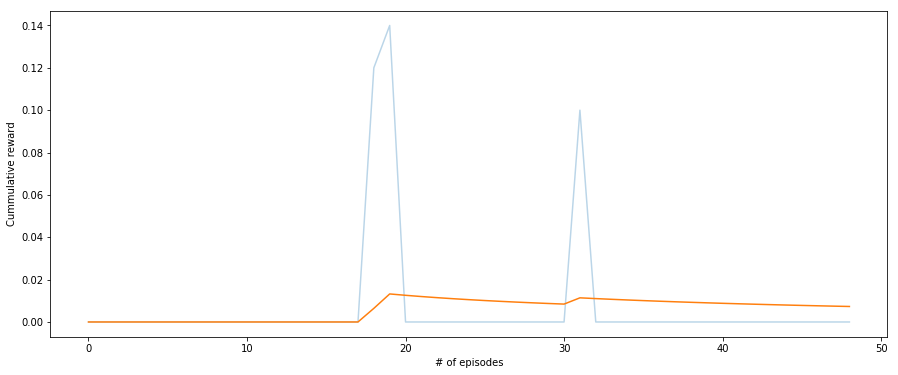

In [ ]:
for episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    agent.reset()
    state = env_info.vector_observations
    score = 0
    done = False
    c = 0
    while not done:
        epsilon = (epsilon_decay)*epsilon + (1-epsilon_decay)*epsilon_min
        # take random action
        action = agent.get_actions(state, epsilon=epsilon, evaluation=True)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        c += 1
        #if c%1000==0:
        #    done=True
        replay_buffer.append([state, action, reward, next_state, done])
        state = next_state
        

        if replay_buffer.length > batch_size:
            states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = replay_buffer.draw_sample(128)
            agent.update(states = states_batch, 
                         actions = actions_batch, 
                         rewards = rewards_batch, 
                         next_states = next_states_batch,
                         dones = dones_batch)
    
    scores.append(score)
    epsilons.append(epsilon)
    clear_output(True)
    plt.figure(figsize=(15, 6))
    #plt.subplot(1,2,1)
    plt.plot(scores, alpha=0.3)
    plt.plot(ewma(scores))
    plt.xlabel("# of episodes")
    plt.ylabel("Cummulative reward")
    #plt.subplot(1,2,2)
    #plt.plot(ewma(epsilons))
    #plt.xlabel("# of episodes")
    #plt.ylabel("Epsilon")
    plt.show()


In [ ]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
done = False
c=0
while not done:
    # take random action
    action = agent.get_greedy_actions(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    c += 1
    if c%200==0:
        done=True
    state = next_state